# Part 1: Базовая модель
### Как в демонстрационном ноутбуке
Построим базовую модель, получим первое предсказание модели и метрику качества. Далее будем её улучшать.

## Библиотеки

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import zipfile
import csv
import sys
import os


import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.regularizers import l2
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.layers import *

from sklearn.model_selection import train_test_split, StratifiedKFold

import PIL
from PIL import ImageOps, ImageFilter
# увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
# графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg'
%matplotlib inline

print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)
print('Keras        :', tf.keras.__version__)

Python       : 3.8.5 (tags/v3.8.5:580fbb0, Jul 20 2020, 15:57:54) [MSC v.1924 64 bit (AMD64)]
Numpy        : 1.18.5
Tensorflow   : 2.3.1
Keras        : 2.4.0


In [2]:
!pip freeze > requirements.txt

## Основные настройки

In [3]:
# В setup выносим основные настройки: так удобнее их перебирать в дальнейшем.

EPOCHS = 5  # эпох на обучение
BATCH_SIZE = 64  # уменьшаем batch если сеть большая, иначе не влезет в память на GPU
LR = 1e-4
VAL_SPLIT = 0.15  # сколько данных выделяем на тест = 15%

CLASS_NUM = 10  # количество классов в нашей задаче
IMG_SIZE = 224  # какого размера подаем изображения в сеть
IMG_CHANNELS = 3   # у RGB 3 канала
input_shape = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

part = 'part_1'  # Версия эксперимента

In [4]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
PYTHONHASHSEED = 0

## EDA / Анализ данных

In [5]:
train_df = pd.read_csv("data/train.csv")
sample_submission = pd.read_csv("data/sample-submission.csv")
train_df.head()

,Id,Category
0,100155.jpg,0
1,100306.jpg,0
2,100379.jpg,0
3,100380.jpg,0
4,100389.jpg,0


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15561 entries, 0 to 15560
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Id        15561 non-null  object
 1   Category  15561 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 243.3+ KB


In [7]:
train_df.Category.value_counts()

1    1971
8    1765
6    1733
5    1631
0    1613
3    1528
2    1458
4    1400
9    1255
7    1207
Name: Category, dtype: int64

Распределение классов достаточно равномерное — это хорошо.

In [8]:
# print('Распаковываем картинки')
# # Will unzip the files so that you can see them..
# for data_zip in ['train.zip', 'test.zip']:
#     with zipfile.ZipFile("data/"+data_zip, "r") as z:
#         z.extractall('data/')

# print(os.listdir('data/'))

Посмотрим на примеры картинок и их размеры чтоб понимать как их лучше обработать и сжимать.

Пример картинок (random sample)


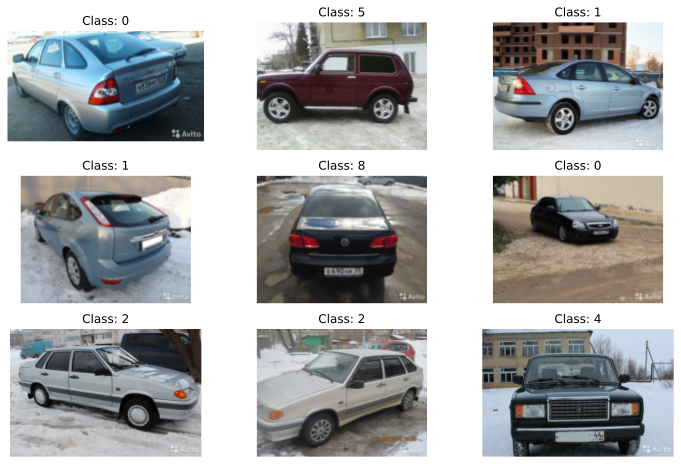

In [9]:
print('Пример картинок (random sample)')
plt.figure(figsize=(12, 8))

random_image = train_df.sample(n=9)
random_image_paths = random_image['Id'].values
random_image_cat = random_image['Category'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(f'data/train/{random_image_cat[index]}/{path}')
    plt.subplot(3, 3, index+1)
    plt.imshow(im)
    plt.title('Class: '+str(random_image_cat[index]))
    plt.axis('off')

plt.show()

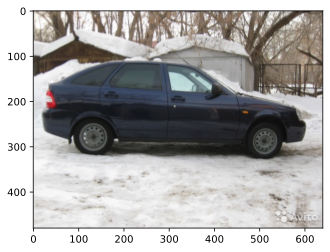

(640, 480)

In [10]:
image = PIL.Image.open('data/train/0/100380.jpg')
imgplot = plt.imshow(image)
plt.show()
image.size

## Подготовка данных
### Аугментация данных

In [11]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=5,
    width_shift_range=0.1,
    height_shift_range=0.1,
    validation_split=VAL_SPLIT,  # set validation split
    horizontal_flip=False)

test_datagen = ImageDataGenerator(rescale=1. / 255)

### Генерация данных

In [12]:
# Завернем наши данные в генератор:
train_generator = train_datagen.flow_from_directory(
    'data/train/',      # директория где расположены папки с картинками
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training')  # set as training data

test_generator = train_datagen.flow_from_directory(
    'data/train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation')  # set as validation data

test_sub_generator = test_datagen.flow_from_dataframe(
    dataframe=sample_submission,
    directory='data/test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE)

Found 13232 images belonging to 10 classes.
Found 2329 images belonging to 10 classes.
Found 6675 validated image filenames.


## Построение модели
### Загружаем предобученную сеть Xception

In [13]:
base_model = Xception(weights='imagenet',
                      include_top=False, input_shape=input_shape)

In [14]:
base_model.summary()

                 
__________________________________________________________________________________________________
block5_sepconv1 (SeparableConv2 (None, 14, 14, 728)  536536      block5_sepconv1_act[0][0]        
__________________________________________________________________________________________________
block5_sepconv1_bn (BatchNormal (None, 14, 14, 728)  2912        block5_sepconv1[0][0]            
__________________________________________________________________________________________________
block5_sepconv2_act (Activation (None, 14, 14, 728)  0           block5_sepconv1_bn[0][0]         
__________________________________________________________________________________________________
block5_sepconv2 (SeparableConv2 (None, 14, 14, 728)  536536      block5_sepconv2_act[0][0]        
__________________________________________________________________________________________________
block5_sepconv2_bn (BatchNormal (None, 14, 14, 728)  2912        block5_sepconv2[0][0]     

In [15]:
# Устанавливаем новую "голову" (head)
x = base_model.output
x = GlobalAveragePooling2D()(x)

# let's add a fully-connected layer
x = Dense(256, activation='relu')(x)
x = Dropout(0.25)(x)

# and a logistic layer -- let's say we have 10 classes
predictions = Dense(CLASS_NUM, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(loss="categorical_crossentropy",
              optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

## Обучение модели
Добавим ModelCheckpoint чтоб сохранять прогресс обучения модели и можно было потом подгрузить и дообучить модель.

In [16]:
checkpoint = ModelCheckpoint('best_model_{}.hdf5'.format(
    part), monitor=['val_accuracy'], verbose=1, mode='max')
callbacks_list = [checkpoint]

### Обучаем

In [17]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=test_generator,
    validation_steps=len(test_generator),
    epochs=EPOCHS,
    callbacks=callbacks_list
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/5
207/207 [==============================] - ETA: 0s - loss: 0.8751 - accuracy: 0.6947 
Epoch 00001: saving model to best_model_part_1.hdf5
207/207 [==============================] - 4869s 24s/step - loss: 0.8751 - accuracy: 0.6947 - val_loss: 0.3628 - val_accuracy: 0.8712
Epoch 2/5
207/207 [==============================] - ETA: 0s - loss: 0.2042 - accuracy: 0.9286 
Epoch 00002: saving model to best_model_part_1.hdf5
207/207 [==============================] - 4808s 23s/step - loss: 0.2042 - accuracy: 0.9286 - val_loss: 0.2405 - val_accuracy: 0.9141
Epoch 3/5
207/207 [==============================] - ETA: 0s - loss: 0.1142 - accuracy: 0.9601 
Epoch 00003: saving model to best_model_part_1.hdf5
207/207 [==============================] - 4796s 23s/step - loss: 0.1142 - accuracy: 0.9601 - val_loss: 0.2389 - val_accuracy: 0.9214
Epoch 4/5
207/207 [==============================] - ETA: 0s - loss: 0.0685 - 

In [18]:
# сохраним итоговую сеть и подгрузим лучшую итерацию в обучении (best_model)
model.save('model_last_{}.hdf5'.format(part))
model.load_weights('best_model_{}.hdf5'.format(part))

### Оценим метрику

In [19]:
scores = model.evaluate_generator(
    test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

Instructions for updating:
Please use Model.evaluate, which supports generators.
37/37 [==============================] - 123s 3s/step - loss: 0.3290 - accuracy: 0.9107
Accuracy: 91.07%


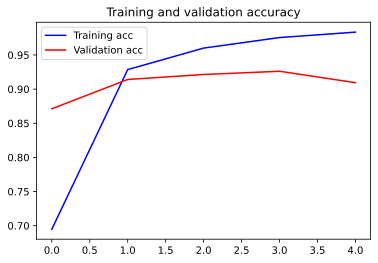

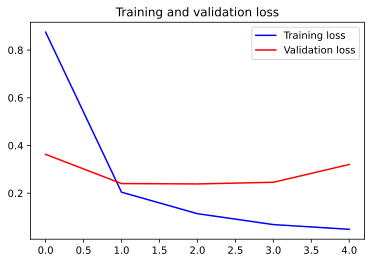

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Предсказание на тестовых данных

In [21]:
test_sub_generator.samples

6675

In [22]:
test_sub_generator.reset()
predictions = model.predict_generator(
    test_sub_generator, steps=len(test_sub_generator), verbose=1)
predictions = np.argmax(predictions, axis=-1)  # multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v, k) for k, v in label_map.items())  # flip k,v
predictions = [label_map[k] for k in predictions]

Instructions for updating:
Please use Model.predict, which supports generators.
105/105 [==============================] - 347s 3s/step


In [23]:
filenames_with_dir = test_sub_generator.filenames
submission = pd.DataFrame(
    {'Id': filenames_with_dir, 'Category': predictions}, columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/', '')
submission.to_csv('submission_{}.csv'.format(part), index=False)
print('Save submit')

Save submit


In [24]:
submission.head()

,Id,Category
0,305108.jpg,7
1,295075.jpg,6
2,31197.jpg,4
3,93598.jpg,7
4,87877.jpg,7


### Вывод по данной части работы:
- Метрика на трейне: 98.34%
- Метрика на валидации: 90.94%
- Метрика на тесте: 91.07%
- Метрика на Kaggle: 92.254%

**Предварительный вывод:** Модель переобучилась. Требуется улучшение параметров.